In [149]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from importlib import reload 

#add simulator to a path
sys.path.append('Simulator/')


import estimation_methods as em
import noise_models as nm
import utils as utl  
import simulation as sm
import analyser as anl

%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
params = {"cycle_time": 1*1e4,  # measurment time (ns)
          "T1": 5*1e5,          # Relaxation time > cycle_time (ns) cycle_time << T1 is means good readout
          "separation/width": 2,  #Separation/width of the gaussians >1 means good readot
          "N_realisations": 200, #Number of realisations
          "dt_realisations": 0, #T_op, time between realisations (ns)
          "N_shots": 5, #Number of shots per realisation
          "trials": 5,    #Number of trials for averaging
          "T2": 1e99,     #T2 time (ns) [fast noise]
          "sigma": 40,    #Standard deviation of the slow noise (MHz) 
            }

In [151]:
MHz2ueV = 4*1e-3


50000000.0
0.206363674024963


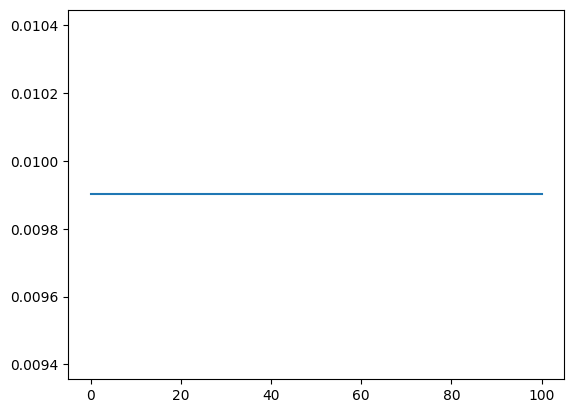

In [201]:
ESTIMATION_SHOTS = 5
ALGORITHM_SHOTS = 1000
SHOT_TIME = 1e4 #in ns
SPIN_TO_CHARGE = 2*1e-4
S1 = 1 #mueV/ns
QUBIT_FREQ = 50 #MHz 
N_TELEGRAPHS = 10

freqs_grid = np.linspace(45, 55, 101)

estimation_method = em.Adaptive_time(freqs_grid = 
                                    freqs_grid,
                                    alpha_beta = (0,1),
                                    N_shots=ESTIMATION_SHOTS, adaptive_prior = False,
                                    cutoff_time = 1e6,
                                    coeff = 10)

estimation_method.init_pdf()

plt.plot(estimation_method.pdf)
simulator = sm.Model(params)

total_time = ESTIMATION_SHOTS * SHOT_TIME * ALGORITHM_SHOTS

print(total_time)

ommin = 1/total_time
ommax = 1/1e4 #max frequency of fluctuations is set to GHZ

print(S1*SPIN_TO_CHARGE/MHz2ueV*np.sqrt(2*np.log(ommax/ommin)))

noise = nm.Over_f_noise(n_telegraphs = N_TELEGRAPHS, S1  = S1*SPIN_TO_CHARGE/MHz2ueV,
                        couplings_dispersion = 0.5, 
                        ommax = ommax , 
                        ommin = ommin, 
                        om0 = QUBIT_FREQ)

def estimate(noise,estimation_method):
    estimation_method.reset_pdf(SHOT_TIME, noise)
    for k in range(estimation_method.N):
        a = simulator.run_single_realisation([estimation_method], noise)

 
    return estimation_method.get_avg()

def get_bit(estimation_method, noise, phi):
    t = phi/estimation_method.get_avg()*1e3
    return (1 + np.cos(noise.omega*t))/2
    


In [109]:
noise.reset_pdf()

AttributeError: 'Over_f_noise' object has no attribute 'reset_pdf'

In [125]:
total_time/1e6

50.0

10
5
5
5
5
5
5
5
5
5
5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_44847/1726057697.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3,1)


10
10
10
10
10
10
10
10
10
10
12.5
12.5
12.5
12.5
12.5
12.5
12.5
12.5
12.5


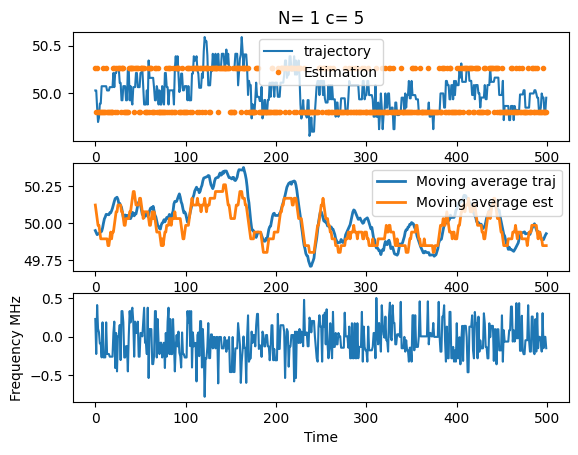

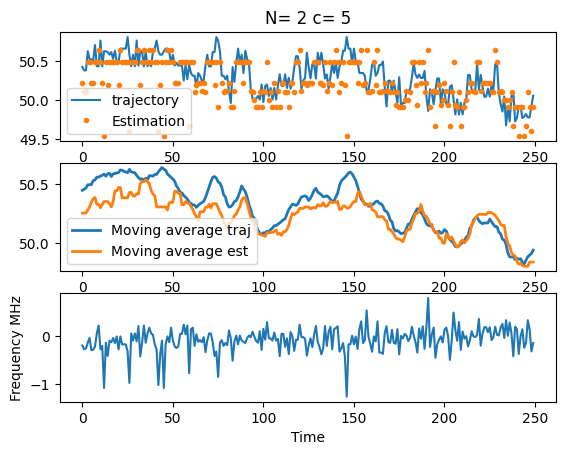

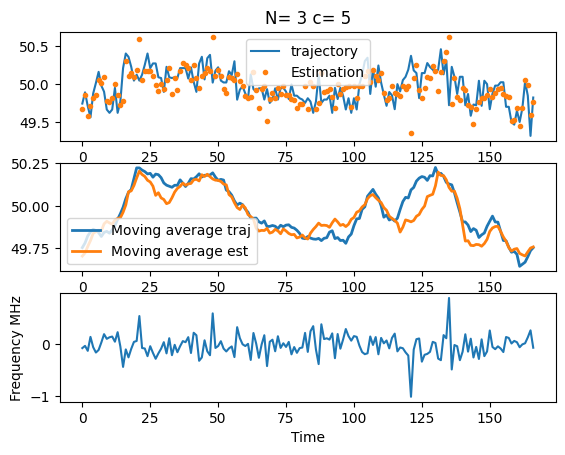

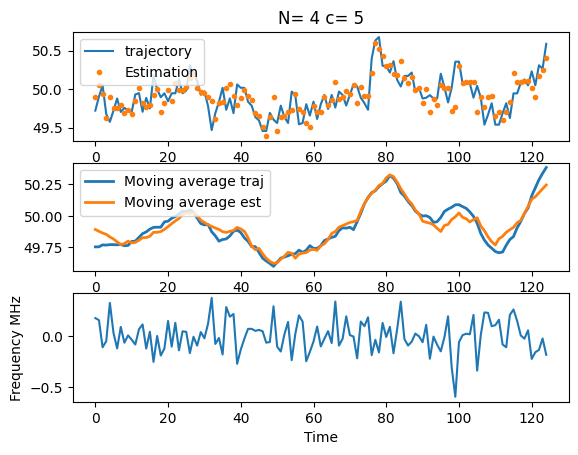

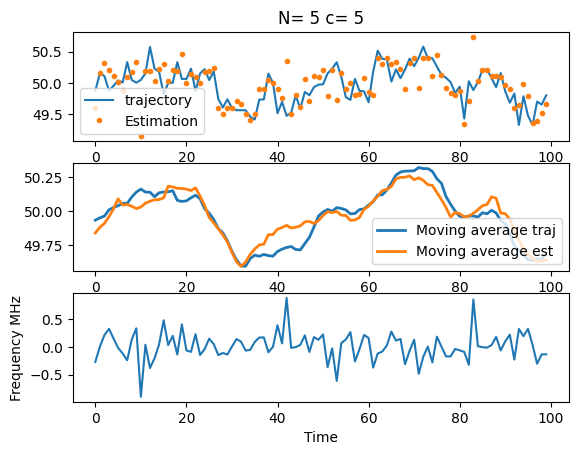

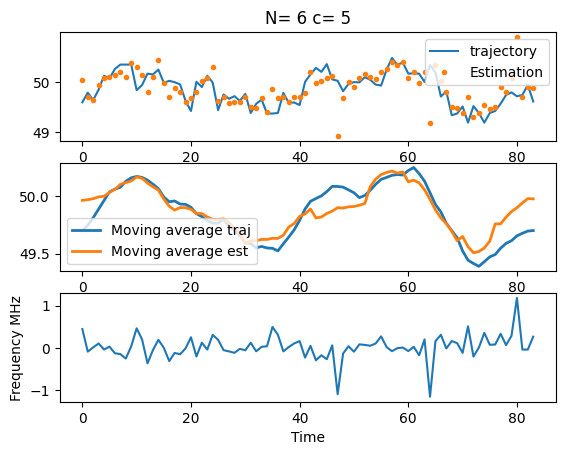

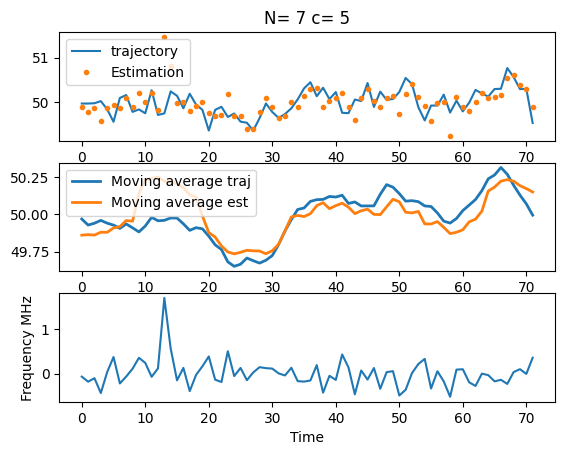

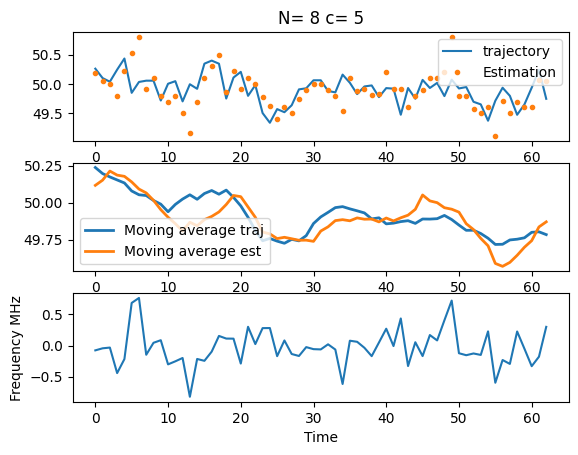

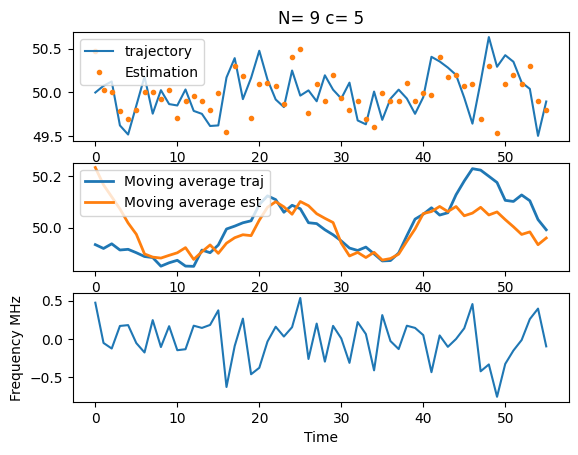

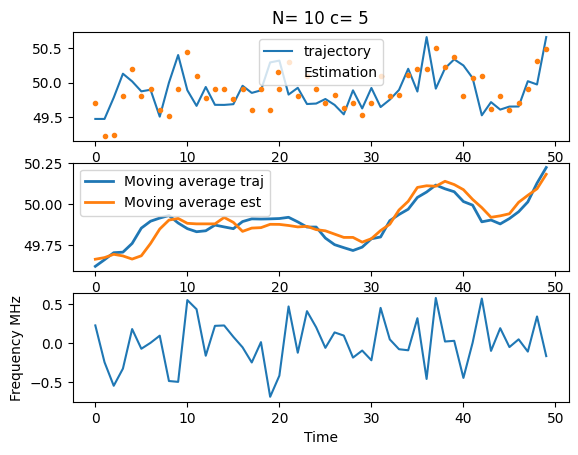

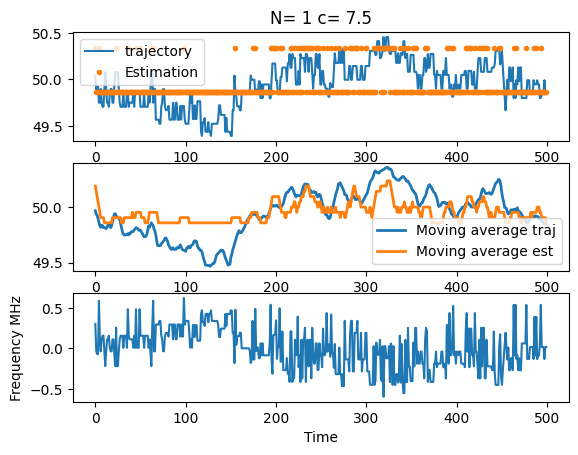

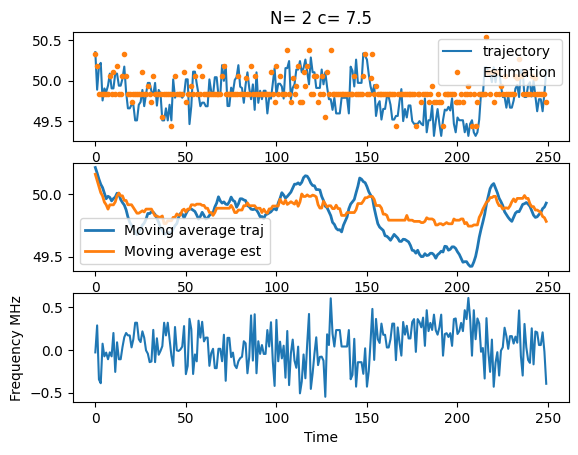

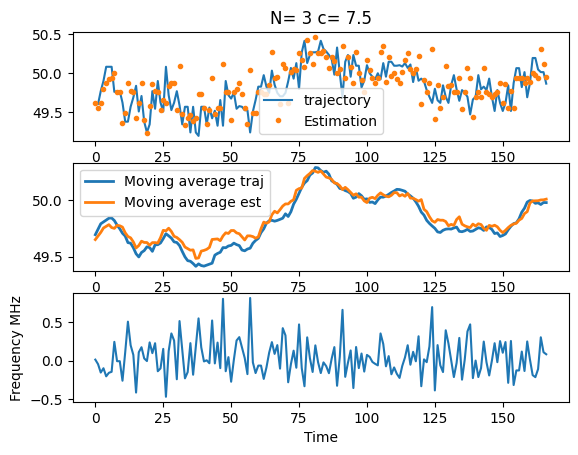

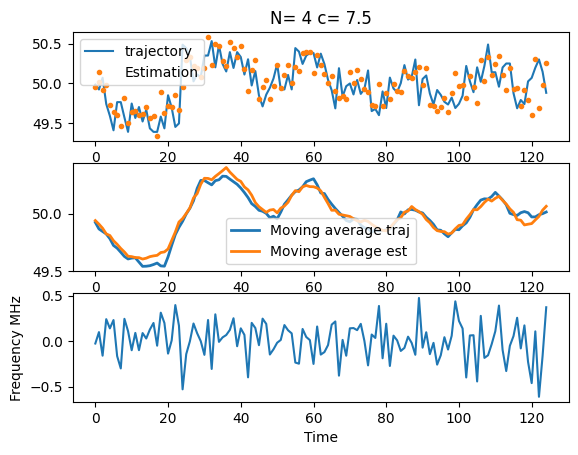

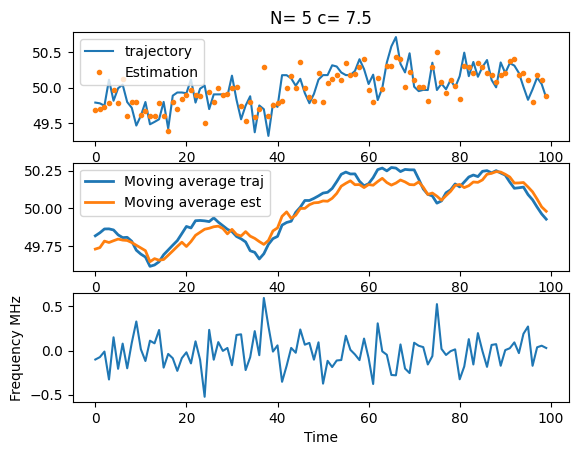

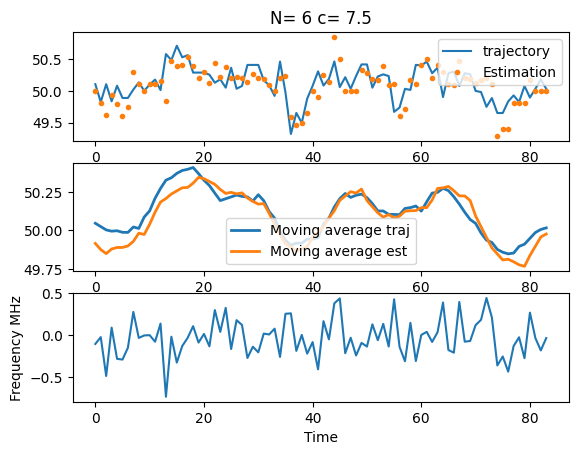

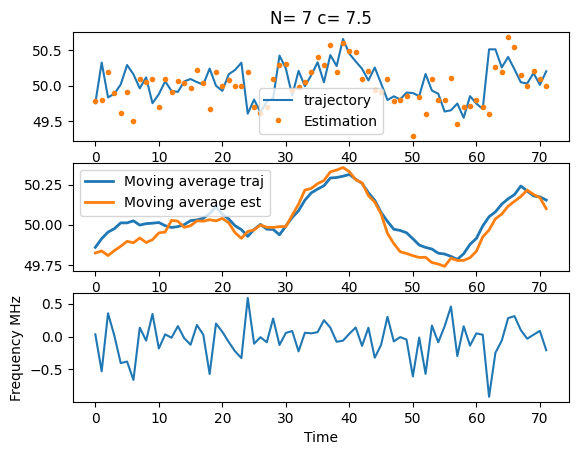

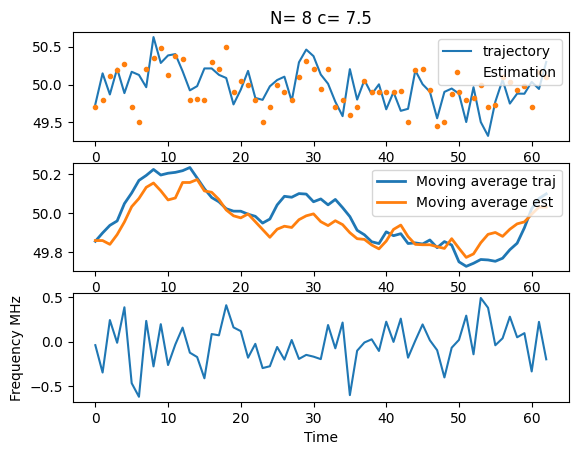

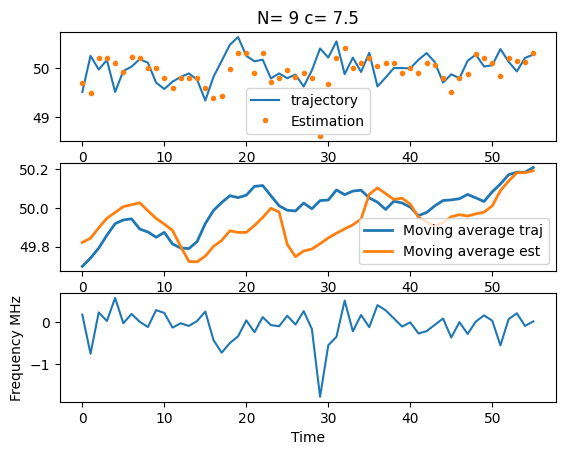

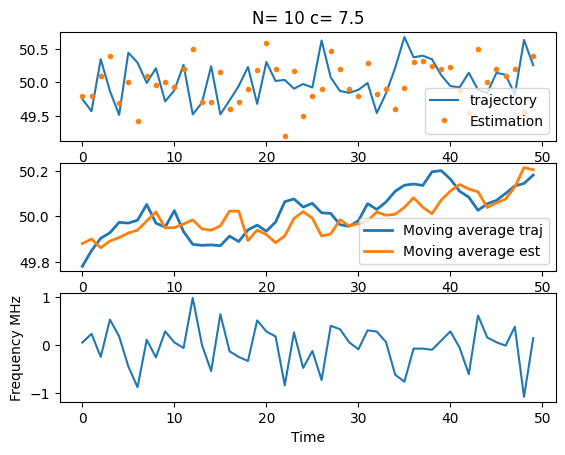

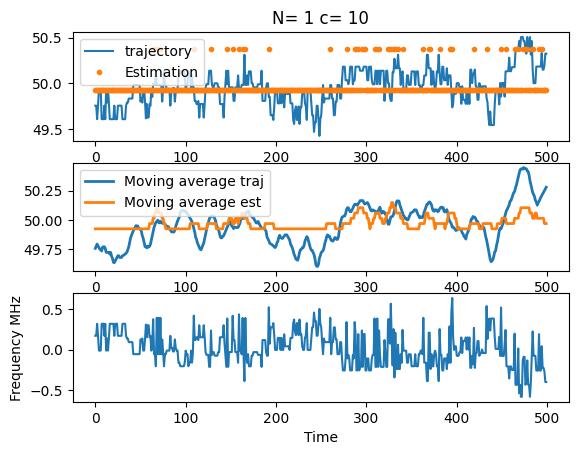

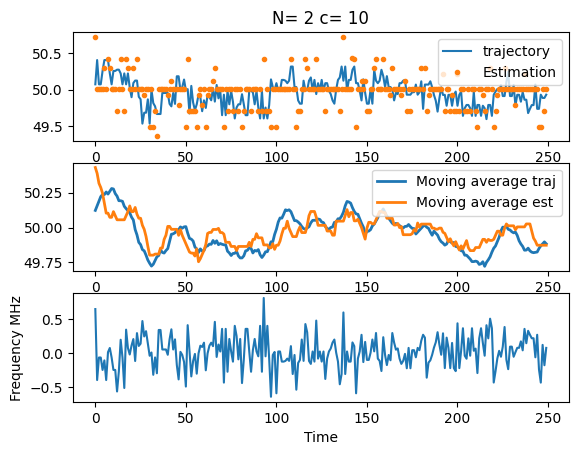

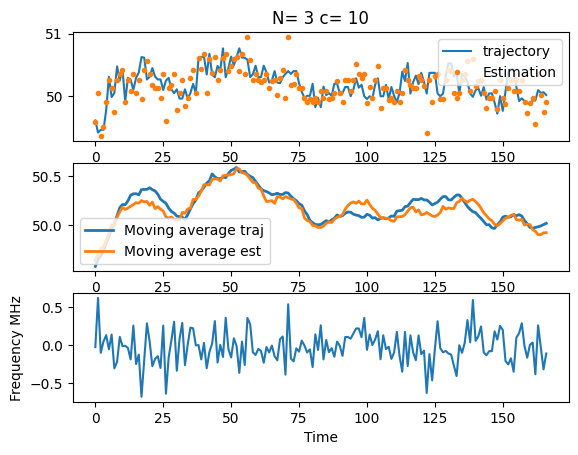

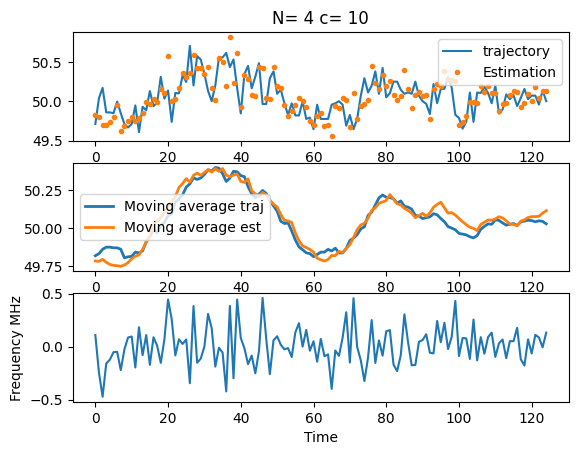

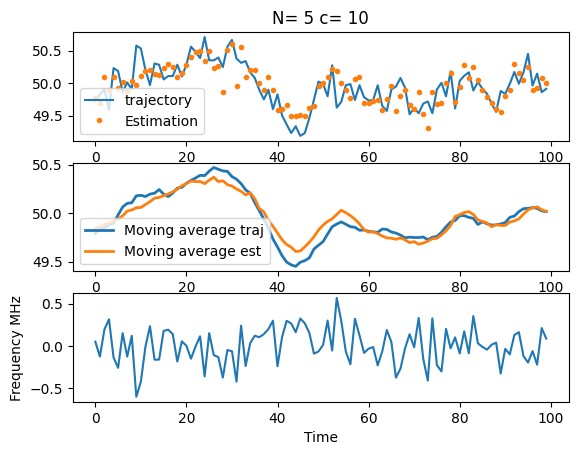

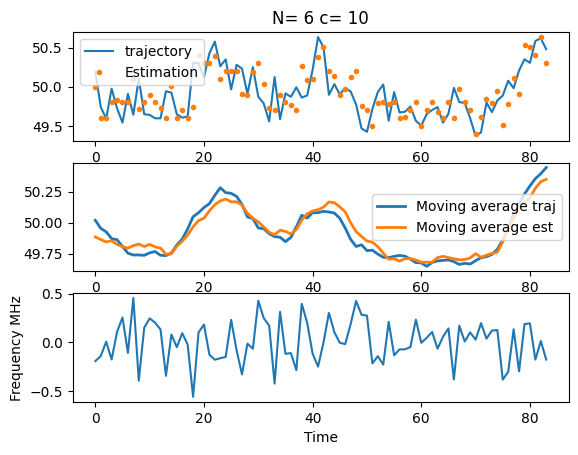

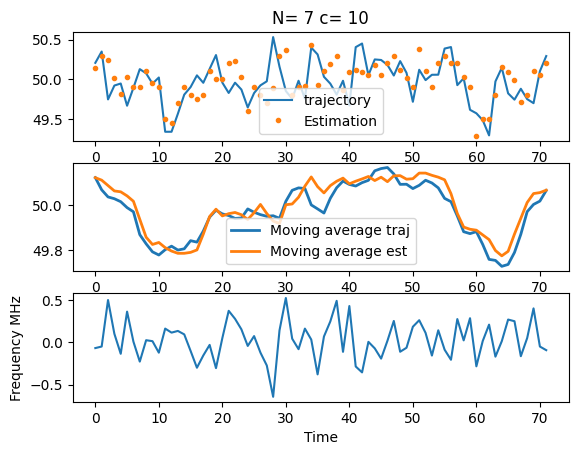

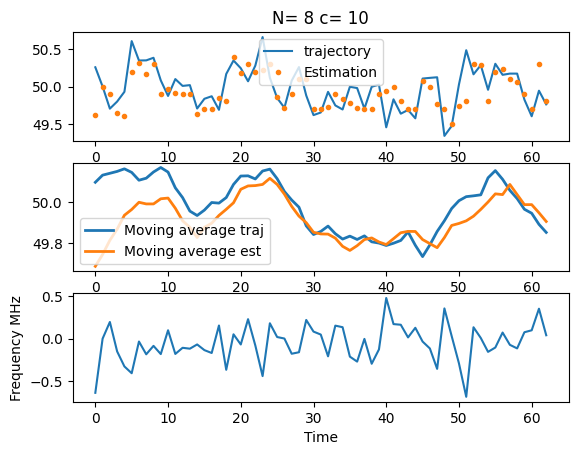

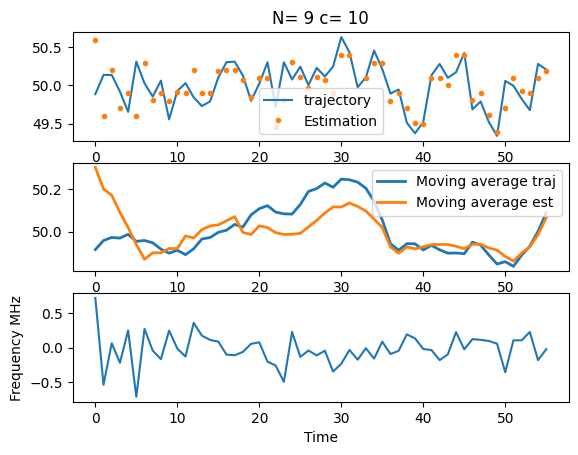

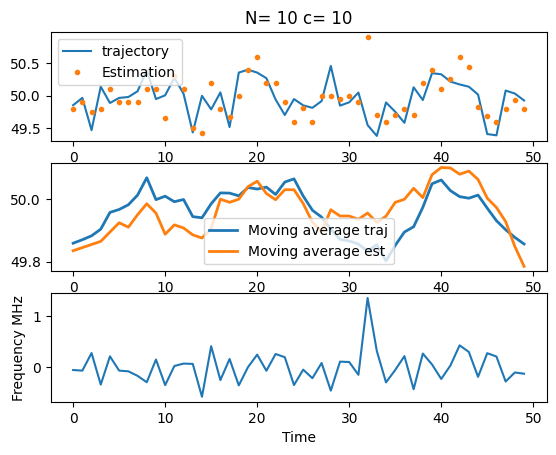

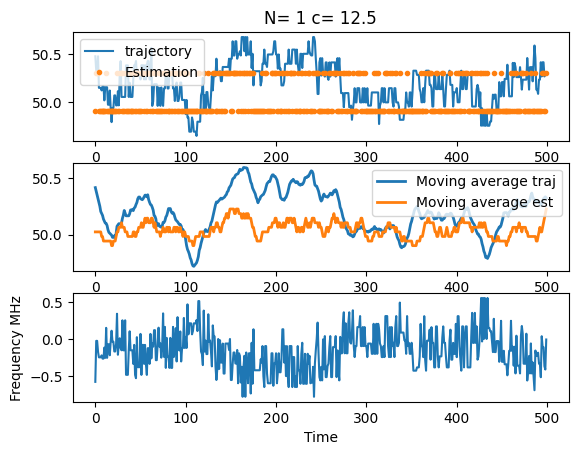

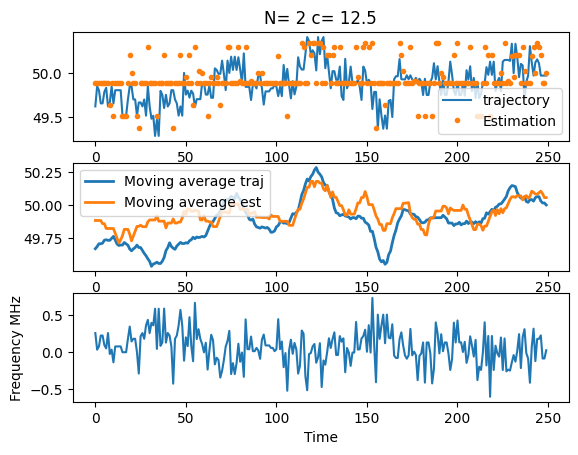

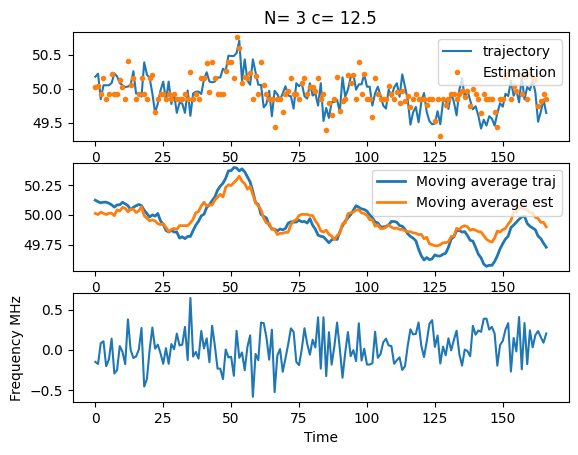

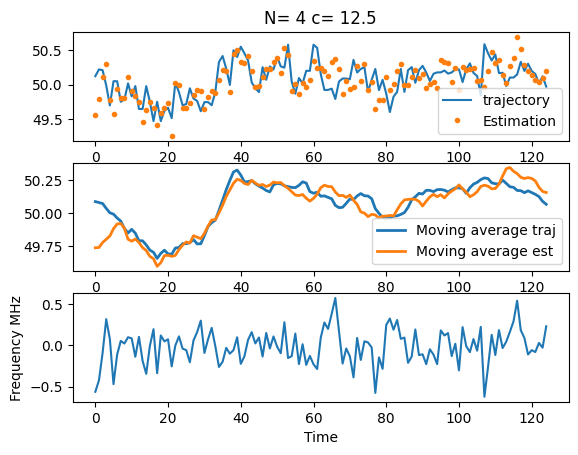

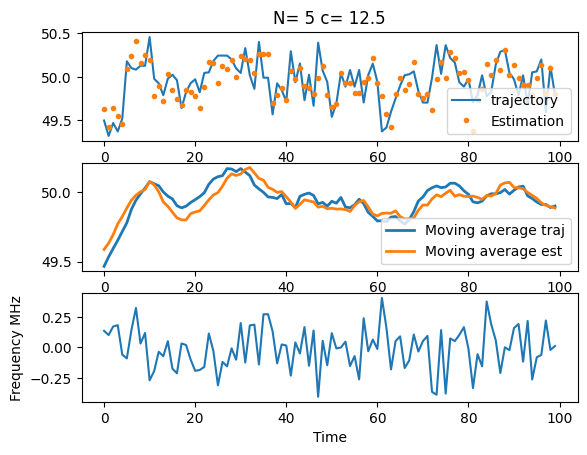

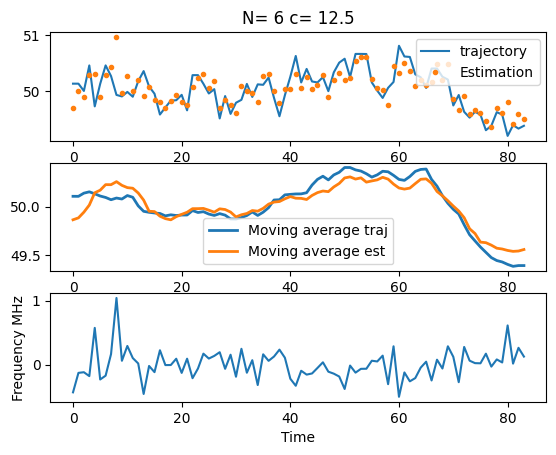

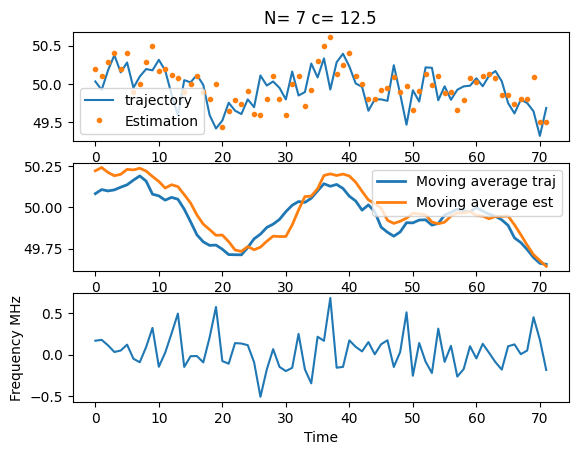

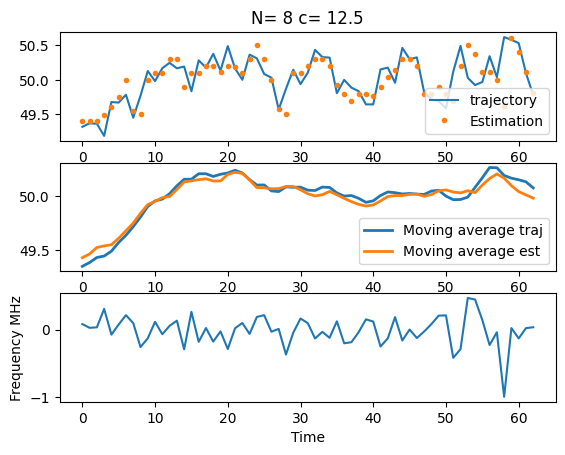

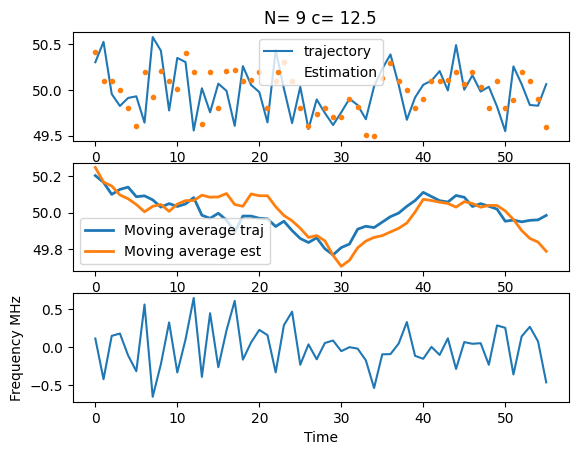

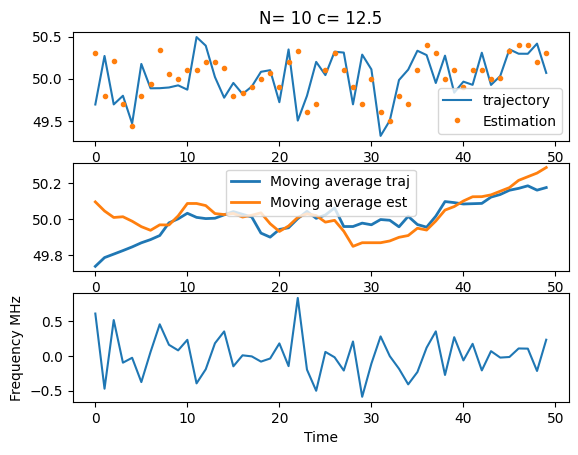

In [202]:
#Asses the best performance
def get_error(x,y):
    return (x-y)**2

def moving_average(x, w):
    N = len(x)
    y_padded = np.pad(x, (w//2, w-1-w//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((w,))/w, mode='valid')
    return y_smooth

ms = 1e6

TRIALS_NUMBER = 20
TRACKING_TIME = 5*ms #ns

MOVING_AVG_TIME = 0.1*ms
cs = [5,7.5,10,12.5]
shots = [1,2,3,4,5,6,7,8,9,10]
ommin = 1/TRACKING_TIME
ommax = 1/SHOT_TIME

errors = np.zeros((len(cs), len(shots),TRIALS_NUMBER ))

for m,c in enumerate(cs):
    for n,Nshot in enumerate(shots):
        print(estimation_method.coeff)
        estimation_method.coeff = c
        estimation_method.N = Nshot
        for trial in range(TRIALS_NUMBER):
            t = 0
            y = []
            est_y = []
            while t < TRACKING_TIME: 
                est_y.append(estimate(noise, estimation_method))
                y.append(noise.x)
                t += SHOT_TIME*Nshot
            

            yslow = moving_average(y, int(MOVING_AVG_TIME/SHOT_TIME))
            est_slow = moving_average(est_y, int(MOVING_AVG_TIME/SHOT_TIME))
            if trial==0:
                fig, ax = plt.subplots(3,1)
                plt.xlabel('Time')
                ax[0].plot(y, "-", label="trajectory")
                ax[0].plot(est_y, ".", label = "Estimation")
                ax[1].plot(yslow, lw=2, label = "Moving average traj", alpha=1)
                ax[1].plot(est_slow,lw=2, label = "Moving average est", alpha=1)
                ax[0].set_title("N= " + str(Nshot)+ " c= " + str(c))
                ax[0].legend()
                ax[1].legend()
                ax[2].plot(np.array(est_y)-np.array(y))
                plt.ylabel('Frequency MHz')
                #add leading zeros in Nshot
                plt.savefig("Nshot_" + str(Nshot)+"c_" +str(c)+ ".png")
                
            y = np.array(y)
            est_y = np.array(est_y)
            
            errors[m,n, trial] = np.average(get_error(y, est_y))
    


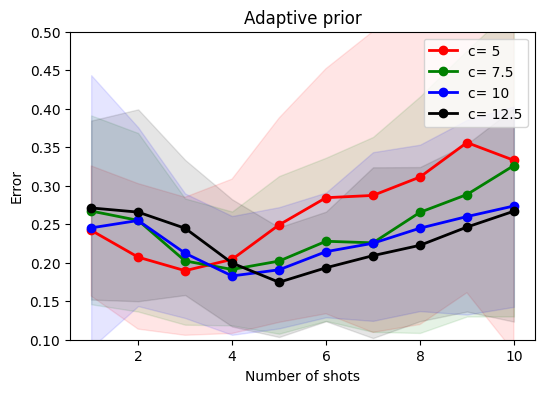

In [219]:
plt.figure(figsize=(6,4))
plt.title("Adaptive prior")
colors = ['r','g','b', "k"]
for k in range(4):
    plt.plot(shots, np.sqrt(np.median(errors[k], axis = 1)), "o-", color = colors[k], lw=2, label="c= " + str(cs[k]))
    plt.fill_between(shots, np.sqrt(np.mean(errors[k], axis = 1)) - np.sqrt(np.std(errors[k], axis = 1)),
                     np.sqrt(np.mean(errors[k], axis = 1)) + np.sqrt(np.std(errors[k], axis = 1)), alpha=0.1, color = colors[k])
plt.legend()
plt.ylim(0.1,0.5)
plt.xlabel('Number of shots')
plt.ylabel('Error')
plt.savefig("Adaptive_prior.png")
#plt.yscale('log')

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


(48.0, 52.0)

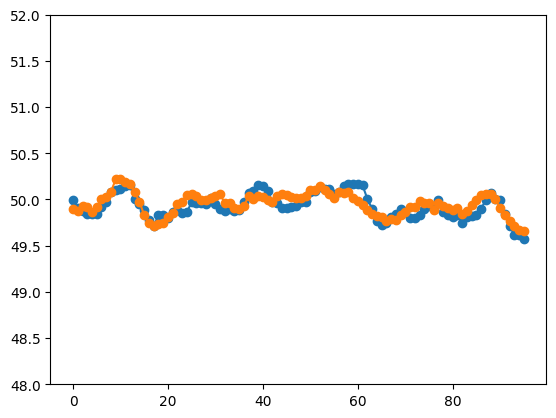

In [113]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

y =  []

est_y = []
for k in range(100):
    y.append(noise.x)
    est_y.append(estimate(noise))
N=5
plt.plot(moving_average(y,N), "o-")
plt.plot(moving_average(est_y,N), "o-")
plt.ylim(48,52)

In [191]:
estimation_method.next_tau(2)

14

50.209640830240474
50.78041308236118


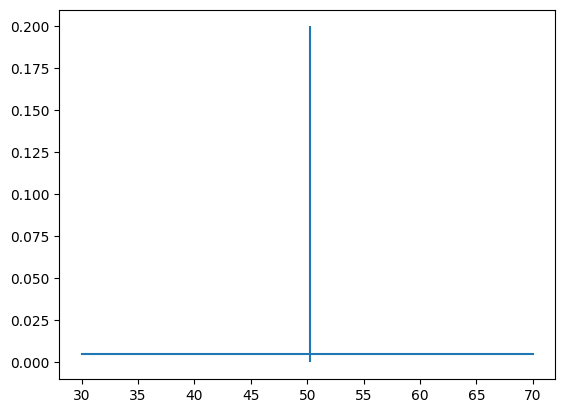

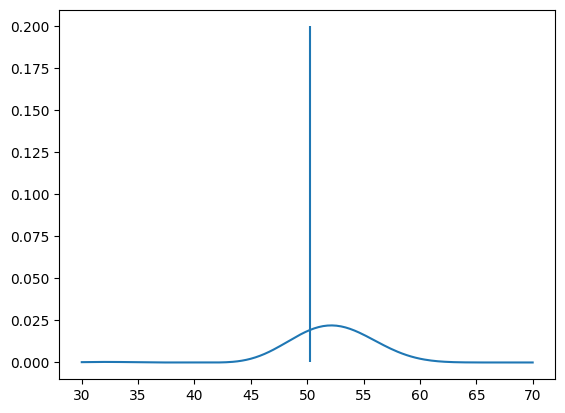

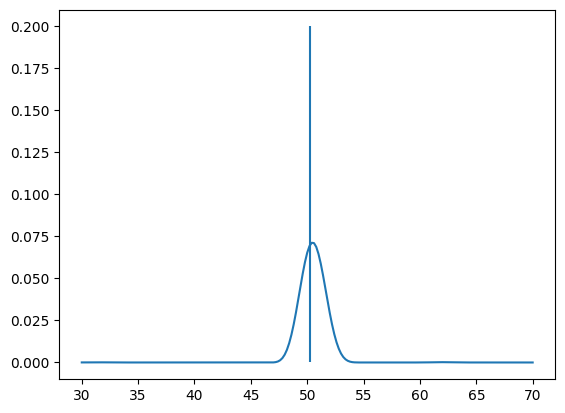

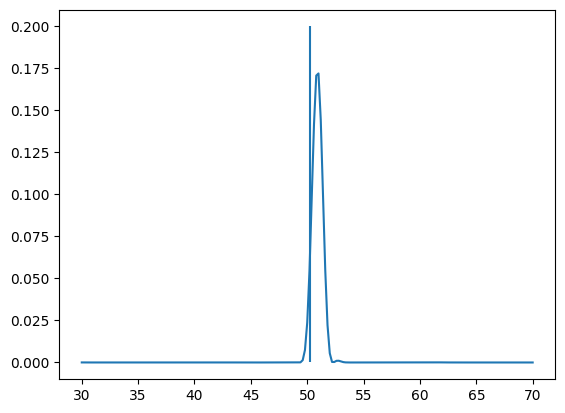

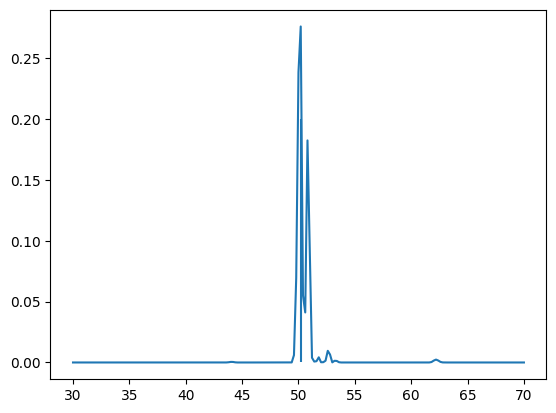

In [202]:
print(noise.x)
print(estimate(noise))

In [169]:

simulator = sm.Model(params)

f0 = 1/(params["cycle_time"]) #frequency od single shot


In [197]:
freqs_grid = np.linspace(2,8,101)
def span_methods(Nshots, params):
    params["N_shots"] = Nshots
    methods = []
    taus_linear = np.linspace(1,params["N_shots"],params["N_shots"])
    freqs_grid = np.linspace(2,8,101)
    alpha_beta = (0,1)

    methods.append(em.Linear_time(freqs_grid = freqs_grid,
                                                                taus = taus_linear*10,
                                                                alpha_beta = alpha_beta,
                                                                adaptive_prior =False,
                                                                add_str=r"$\tau_0=10$ns"))



    methods.append(em.Linear_time(freqs_grid = freqs_grid,
                                                                taus = taus_linear*20,
                                                                alpha_beta =  alpha_beta,
                                                                adaptive_prior =False,
                                                                add_str=r"_$\tau_0=20$ns"))

    methods.append(em.Random_time_window(freqs_grid = freqs_grid,
                                                        times_window=(0,100),
                                                        alpha_beta = alpha_beta,
                                                        adaptive_prior =False,
                                                        N_shots=params["N_shots"]))


    cs = [6]
    for c in cs:
        methods.append(em.Adaptive_time(freqs_grid = 
                                            freqs_grid,
                                            alpha_beta = alpha_beta,
                                            N_shots=params["N_shots"], adaptive_prior = False,
                                            cutoff_time = 1e4,
                                            coeff = c))
    

                        

    print("Implemented")
    print("".join([str(s)+":"+str(methods[s])+"\n" for s in range(len(methods))]))
    return params, methods

### 2. Track down a single trial

Here we plot single realisation of the noise vs the real field

In [105]:
gammas

array([9.54992586e-01, 3.81944271e-01, 1.52756606e-01, 6.10942025e-02,
       2.44343055e-02, 9.77237221e-03, 3.90840896e-03, 1.56314764e-03,
       6.25172693e-04, 2.50034536e-04, 1.00000000e-04])

In [231]:

gammas = [f0/500, f0/100, f0/20]
print(gammas)
N_total_shots =np.arange(1, 11, 1)
print(N_total_shots)
params["trials"] = 50
vars = []
errors = []
traj_gam = []
mu_gam = []
pdf_gam = []


for gam in gammas:    
    vars_gam = []
    errors_gam = []
    print(gam)
    noise = nm.Telegraph_Noise(sigma = 1, gamma= gam, x0 = 5)
    for N in N_total_shots:


      
        params, methods = span_methods(N, params)
        stats_var, stats_err = anl.get_statistics_over_trials(methods, noise, simulator)
        vars_gam.append(stats_var)
        errors_gam.append(stats_err)
        if N == N_total_shots[-1]:
            times_traj = np.arange(0,1e9,1e4) #If there is an error, increase upper limit

            Trajectory = nm.SingleTrajectory(times_traj, noise_process=noise)
            data_tracker = []
            for method in methods:
                data_tracker0, pdfs0, tracker0 = simulator.track_down(methods = [method], 
                    noise = Trajectory)


                data_tracker.append(data_tracker0)   # originally data_dracker0[realisation][method], so we use [0] to get the only method

  

            Nreal  = params["N_realisations"]
            Nshots = N

            pdfs_array0 = np.zeros((len(methods),Nreal,Nshots+1,len(freqs_grid)))
            stds0 = np.zeros((len(methods),Nreal,Nshots+1))
            errors0 = np.zeros((len(methods),Nreal,Nshots+1))
            om_real0 = np.zeros((len(methods),Nreal, Nshots+1))
            mus0 = np.zeros((len(methods),Nreal, Nshots+1))
            for s in range(Nshots+1):
                for m in range(len(methods)):
                    for n in range(Nreal):
                        om_real0[m,n,s] = np.abs(data_tracker[m][n][0][s][-2])
                        pdfs_array0[m,n,s,:] = data_tracker[m][n][0][s][-1]
                        stds0[m,n,s] = np.sqrt(np.sum(freqs_grid**2*pdfs_array0[m,n,s]) - np.sum(freqs_grid*pdfs_array0[m,n,s])**2)
                        mu = freqs_grid[np.argmax(pdfs_array0[m,n,s])] #using the mode not the average
                        mus0[m,n,s] = mu
                        errors0[m,n,s] = np.abs(np.abs(om_real0[m,n,s]) - mu)


            traj_gam.append(om_real0)
            mu_gam.append(mus0)
            pdf_gam.append(pdfs_array0)



    vars.append(vars_gam)
    errors.append(errors_gam)


# Structure of the data after wra[[omg]]:
# data_tracker[method][realisation][shot] = [shot, time, bit, tau, om_real, pdf]
# pdfs[realisation][method] = pdf
# tracker[realisation] = [time, om_real, om_est(method1), om_est(method2), ...]



[2.0000000000000002e-07, 1e-06, 5e-06]
[ 1  2  3  4  5  6  7  8  9 10]
2.0000000000000002e-07
Implemented
0:Linear_time$\tau_0=10$ns
1:Linear_time_$\tau_0=20$ns
2:Random_time
3:Adaptive_time_c_6
4:Chi_square

0.0%
2.0%
4.0%
6.0%
8.0%
10.0%
12.0%
14.0%
16.0%
18.0%
20.0%
22.0%
24.0%
26.0%
28.0%
30.0%
32.0%
34.0%
36.0%
38.0%
40.0%
42.0%
44.0%
46.0%
48.0%
50.0%
52.0%
54.0%
56.0%
58.0%
60.0%
62.0%
64.0%
66.0%
68.0%
70.0%
72.0%
74.0%
76.0%
78.0%
80.0%
82.0%
84.0%
86.0%
88.0%
90.0%
92.0%
94.0%
96.0%
98.0%
Implemented
0:Linear_time$\tau_0=10$ns
1:Linear_time_$\tau_0=20$ns
2:Random_time
3:Adaptive_time_c_6
4:Chi_square

0.0%
2.0%
4.0%
6.0%
8.0%
10.0%
12.0%
14.0%
16.0%
18.0%
20.0%
22.0%
24.0%
26.0%
28.0%
30.0%
32.0%
34.0%
36.0%
38.0%
40.0%
42.0%
44.0%
46.0%
48.0%
50.0%
52.0%
54.0%
56.0%
58.0%
60.0%
62.0%
64.0%
66.0%
68.0%
70.0%
72.0%
74.0%
76.0%
78.0%
80.0%
82.0%
84.0%
86.0%
88.0%
90.0%
92.0%
94.0%
96.0%
98.0%
Implemented
0:Linear_time$\tau_0=10$ns
1:Linear_time_$\tau_0=20$ns
2:Random_time
3:Ada

In [232]:
stats_var_r = np.zeros((stats_var.shape[0],len(vars),len(vars[0]),vars[0][0].shape[1]*vars[0][0].shape[2]))
stats_err_r = np.zeros((stats_err.shape[0],len(vars),len(vars[0]),vars[0][0].shape[1]*vars[0][0].shape[2]))
for gm_ind in range(len(vars)):
    for shot_ind in range(len(vars[0])):
        stats_var_r[:,gm_ind, shot_ind,:] = vars[gm_ind][shot_ind][:,:,:,-1].reshape(len(methods),vars[gm_ind][shot_ind].shape[1]*vars[gm_ind][shot_ind].shape[2])
        stats_err_r[:,gm_ind, shot_ind,:] = np.abs(errors[gm_ind][shot_ind][:,:,:,-1].reshape(len(methods),errors[gm_ind][shot_ind].shape[1]*errors[gm_ind][shot_ind].shape[2]))

In [208]:
stats_var_r.shape

(5, 3, 5, 2000)

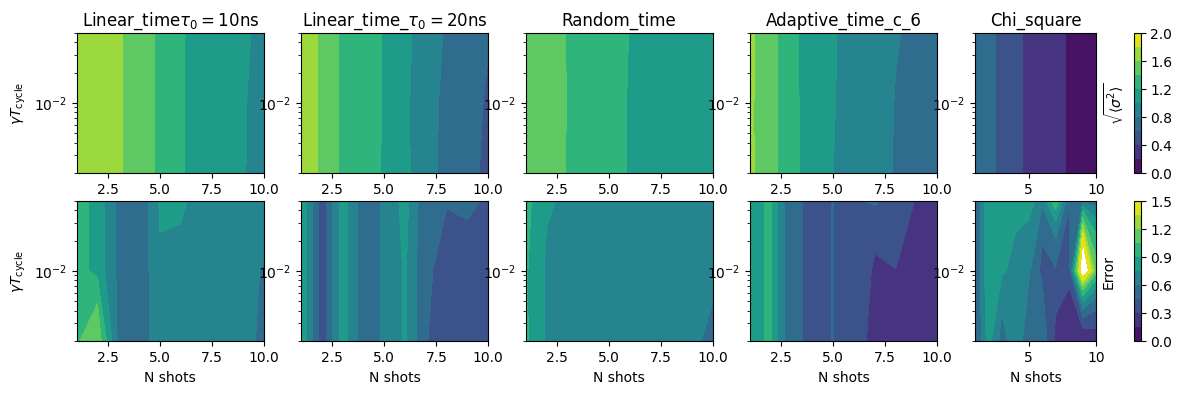

In [235]:


fig, ax = plt.subplots(2,5,figsize = (14,4))
X,Y = np.meshgrid(N_total_shots, np.array(gammas)/f0)
for m in range(5):
    ax[0,m].set_title(str(methods[m]))
    for i in range(2):
        ax[i,m].set_yscale("log")
        ax[i,0].set_ylabel(r"$\gamma T_\mathrm{cycle}$")
    vr = ax[0,m].contourf(X,Y,np.sqrt(np.average(stats_var_r[m,:,:],axis=-1)), levels = np.linspace(0,2,11))
    er = ax[1,m].contourf(X,Y,np.median(np.abs(stats_err_r[m,:,:]),axis=-1), levels = np.linspace(0,1.5,11))
    
    ax[1,m].set_xlabel("N shots")
    
    ax[0,-1].set_ylabel(r"$\sqrt{\langle \sigma^2 \rangle}$")
    ax[1,-1].set_ylabel(r"Error")
    # set y-axis label to the right
    ax[0,-1].yaxis.set_label_position("right")
    ax[1,-1].yaxis.set_label_position("right")

plt.colorbar(vr, pad=0.2)
plt.colorbar(er,pad=0.2)




In [45]:
traj_gam[g][m,:,-1]

array([6., 4., 6., 6., 4., 6., 6., 4., 6., 4., 6., 6., 6., 4., 4., 6., 4.,
       4., 4., 4., 6., 4., 6., 4., 6., 6., 6., 6., 6., 6., 4., 4., 6., 4.,
       6., 4., 6., 6., 4., 4., 4., 4., 6., 6., 4., 6., 4., 4., 4., 6., 6.,
       6., 6., 4., 6., 4., 4., 4., 6., 6., 6., 6., 4., 6., 4., 6., 6., 4.,
       4., 4., 4., 4., 4., 6., 6., 6., 4., 6., 4., 4., 6., 4., 4., 6., 4.,
       6., 4., 6., 6., 4., 4., 6., 6., 4., 4., 4., 4., 4., 4., 4.])

In [89]:
print(gammas)

[0.0001, 1.0]


Text(0.5, 0, 'N shots')

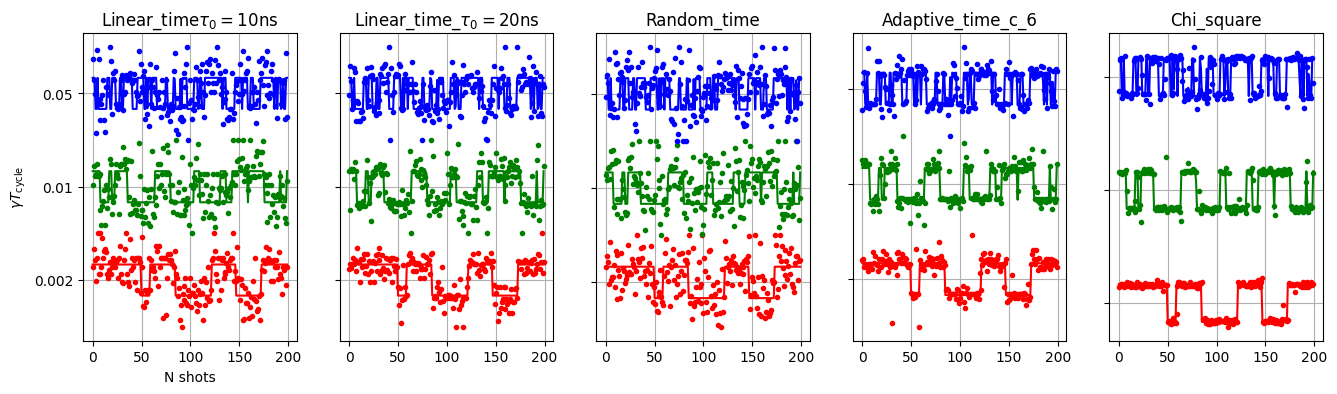

In [236]:

fig, ax = plt.subplots(1,5, figsize = (16,4))
X,Y = np.meshgrid(N_total_shots, gammas)
shift = 6
colors = ["r", "g", "b"]


#colors = ["r","g","b"]
for m in range(5):
    ax[m].set_title(str(methods[m]))
    for g in range(len(gammas)):
            ax[m].plot(traj_gam[g][m,:,-1]+g*shift, alpha=1, color = colors[g])
            ax[m].plot(mu_gam[g][m,:,-1]+g*shift, '.', color = colors[g])

    ax[m].set_yticks(np.arange(len(gammas))*shift+5)
    ax[m].set_yticklabels([])
    ax[m].grid(True)
gammas_floor = np.round(np.array(gammas)/f0,3)
ax[0].set_yticklabels(gammas_floor)
ax[0].set_ylabel(r"$\gamma T_\mathrm{cycle}$")
ax[0].set_xlabel("N shots")



[1, 2, 3, 4, 5]
[[[[8.49942913 8.49942913 8.49942913 ... 8.49942913 8.49942913
    8.49942913]
   [8.49713556 8.49713556 8.49713556 ... 8.49713556 8.49713556
    8.49713556]
   [8.49192002 8.49192002 8.49192002 ... 8.49192002 8.49192002
    8.49192002]
   [8.48246726 8.48246726 8.48246726 ... 8.48246726 8.48246726
    8.48246726]
   [8.4672475  8.4672475  8.4672475  ... 8.4672475  8.4672475
    8.4672475 ]]

  [[8.49942913 8.49942913 8.49942913 ... 8.49942913 8.49942913
    8.49942913]
   [8.49713556 8.49713556 8.49713556 ... 8.49713556 8.49713556
    8.49713556]
   [8.49192002 8.49192002 8.49192002 ... 8.49192002 8.49192002
    8.49192002]
   [8.48246726 8.48246726 8.48246726 ... 8.48246726 8.48246726
    8.48246726]
   [8.4672475  8.4672475  8.4672475  ... 8.4672475  8.4672475
    8.4672475 ]]

  [[8.49942913 8.49942913 8.49942913 ... 8.49942913 8.49942913
    8.49942913]
   [8.49713556 8.49713556 8.49713556 ... 8.49713556 8.49713556
    8.49713556]
   [8.49192002 8.49192002 8.491920

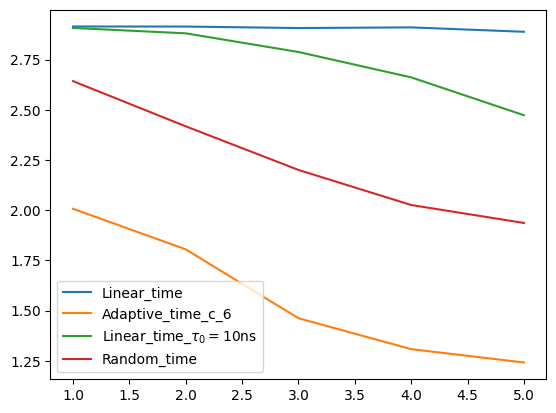

In [20]:
print(N_total_shots)
print(stats_var_r)
for m in range(4):   
    plt.plot(N_total_shots,  np.sqrt(np.average(stats_var_r[m,0,:],axis=-1)), label = str(methods[m]))
plt.legend()
#plt.yscale("log")

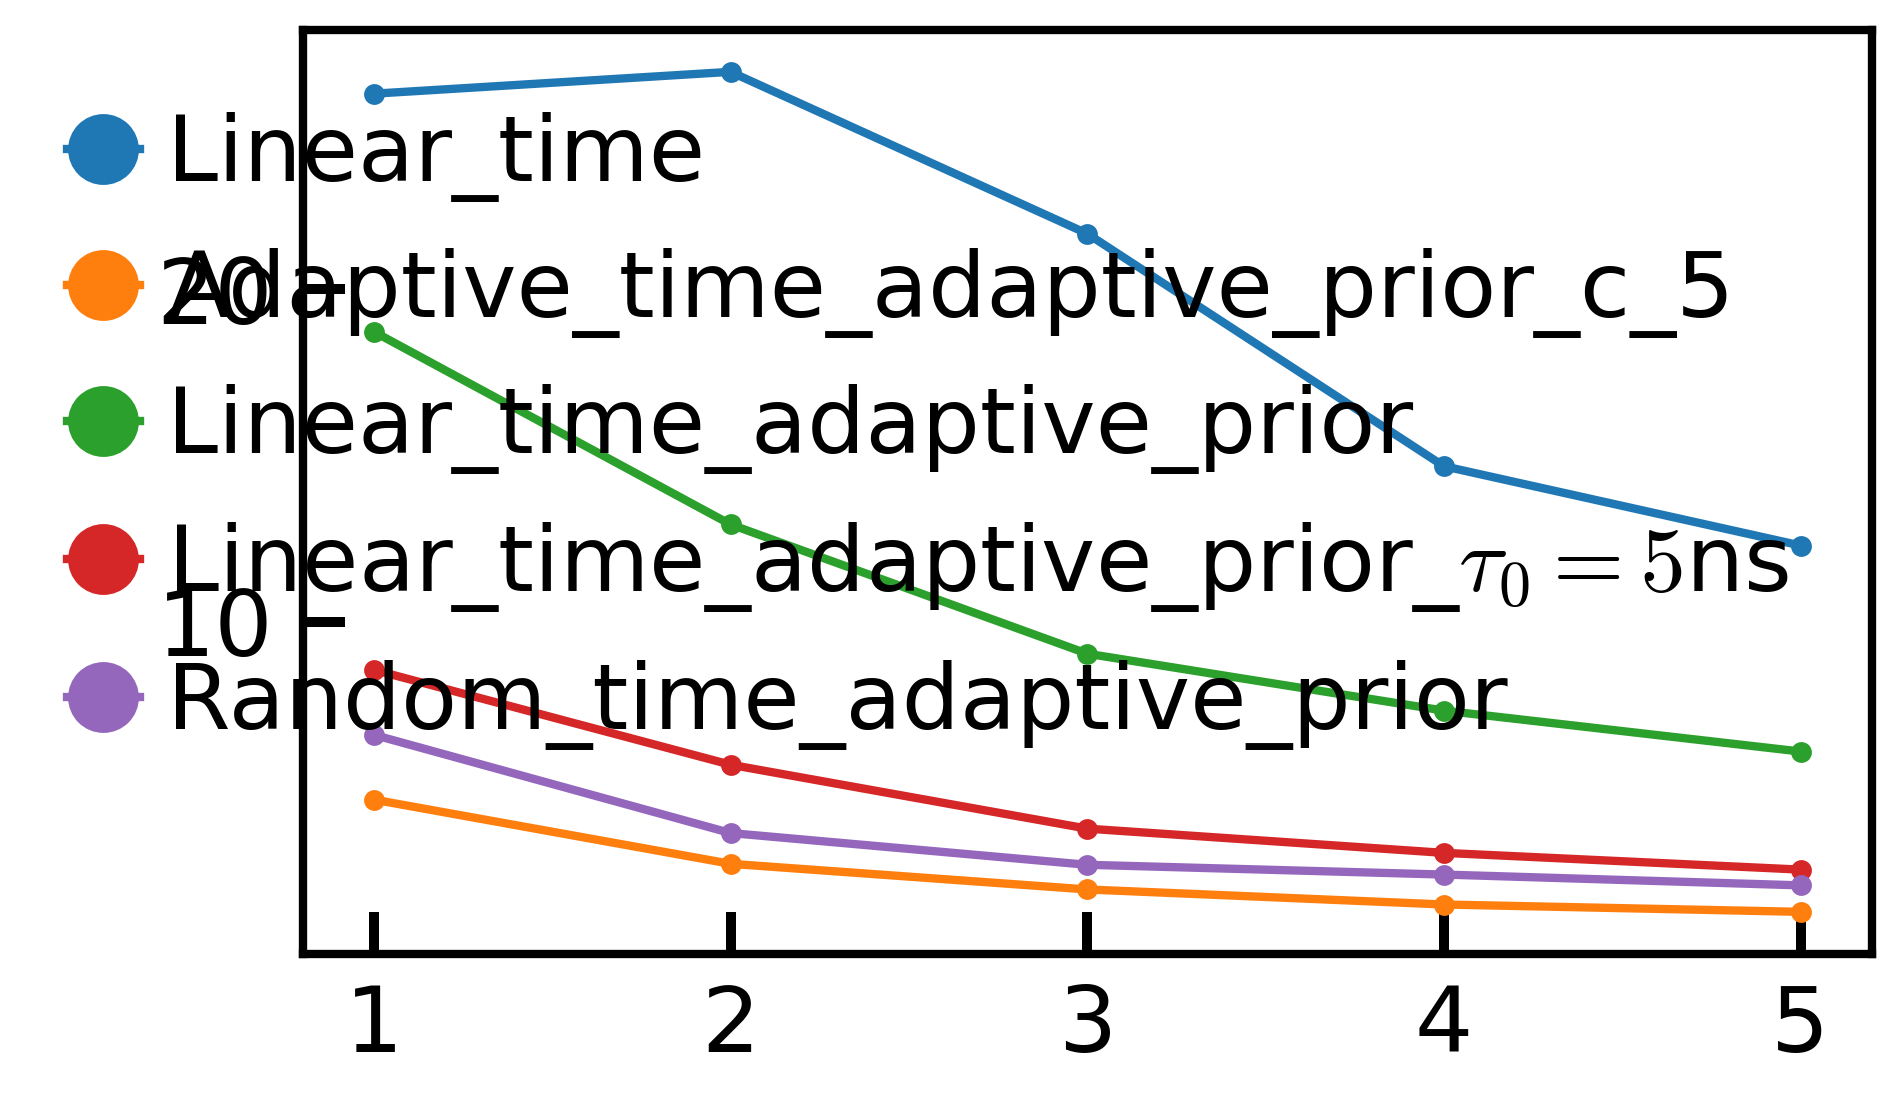

In [194]:
for m in range(5):   
    plt.plot(N_total_shots,  np.abs(stats_err_r[:,m]), label = str(methods[m]))
plt.legend()
#plt.yscale("log")

In [ ]:
for m in range(5):   
    plt.plot(N_total_shots,  stats_err_r[m,:], label = str(methods[m]))
plt.legend()

In [42]:
plt.plot(cs,stats_var_r[0,:],label="N=5")
plt.plot(cs,stats_var_r[1,:],label="N=10")
plt.plot(cs,stats_var_r[2,:],label="N=25")

In [48]:

# Here we wrap the data_tracker to generate fig 4 like.
Nreal  = params["N_realisations"]
Nshots = params["N_shots"]

results_total = []

for k in range(len(N_total_shots)):
    Nshots = N_total_shots[k]
    pdfs_array = np.zeros((len(methods),Nreal,Nshots+1,len(freqs_grid)))
    stds = np.zeros((len(methods),Nreal,Nshots+1))
    errors = np.zeros((len(methods),Nreal,Nshots+1))
    om_real = np.zeros((len(methods),Nreal, Nshots+1))
    for s in range(Nshots+1):
        for m in range(len(methods)):
            for n in range(Nreal):
                om_real[m,n,s] = np.abs(data_tracker_total[k][m][n][0][s][-2])
                pdfs_array[m,n,s,:] = data_tracker_total[k][m][n][0][s][-1]
                stds[m,n,s] = np.sqrt(np.sum(freqs_grid**2*pdfs_array[m,n,s]) - np.sum(freqs_grid*pdfs_array[m,n,s])**2)
                mu = freqs_grid[np.argmax(pdfs_array[m,n,s])] #using the mode not the average
            errors[m,n,s] = np.abs(np.abs(om_real[m,n,s]) - mu)
    results_total.append([pdfs_array, stds, errors, om_real])

In [24]:
results_total[0][1].shape

(5, 4000, 2)

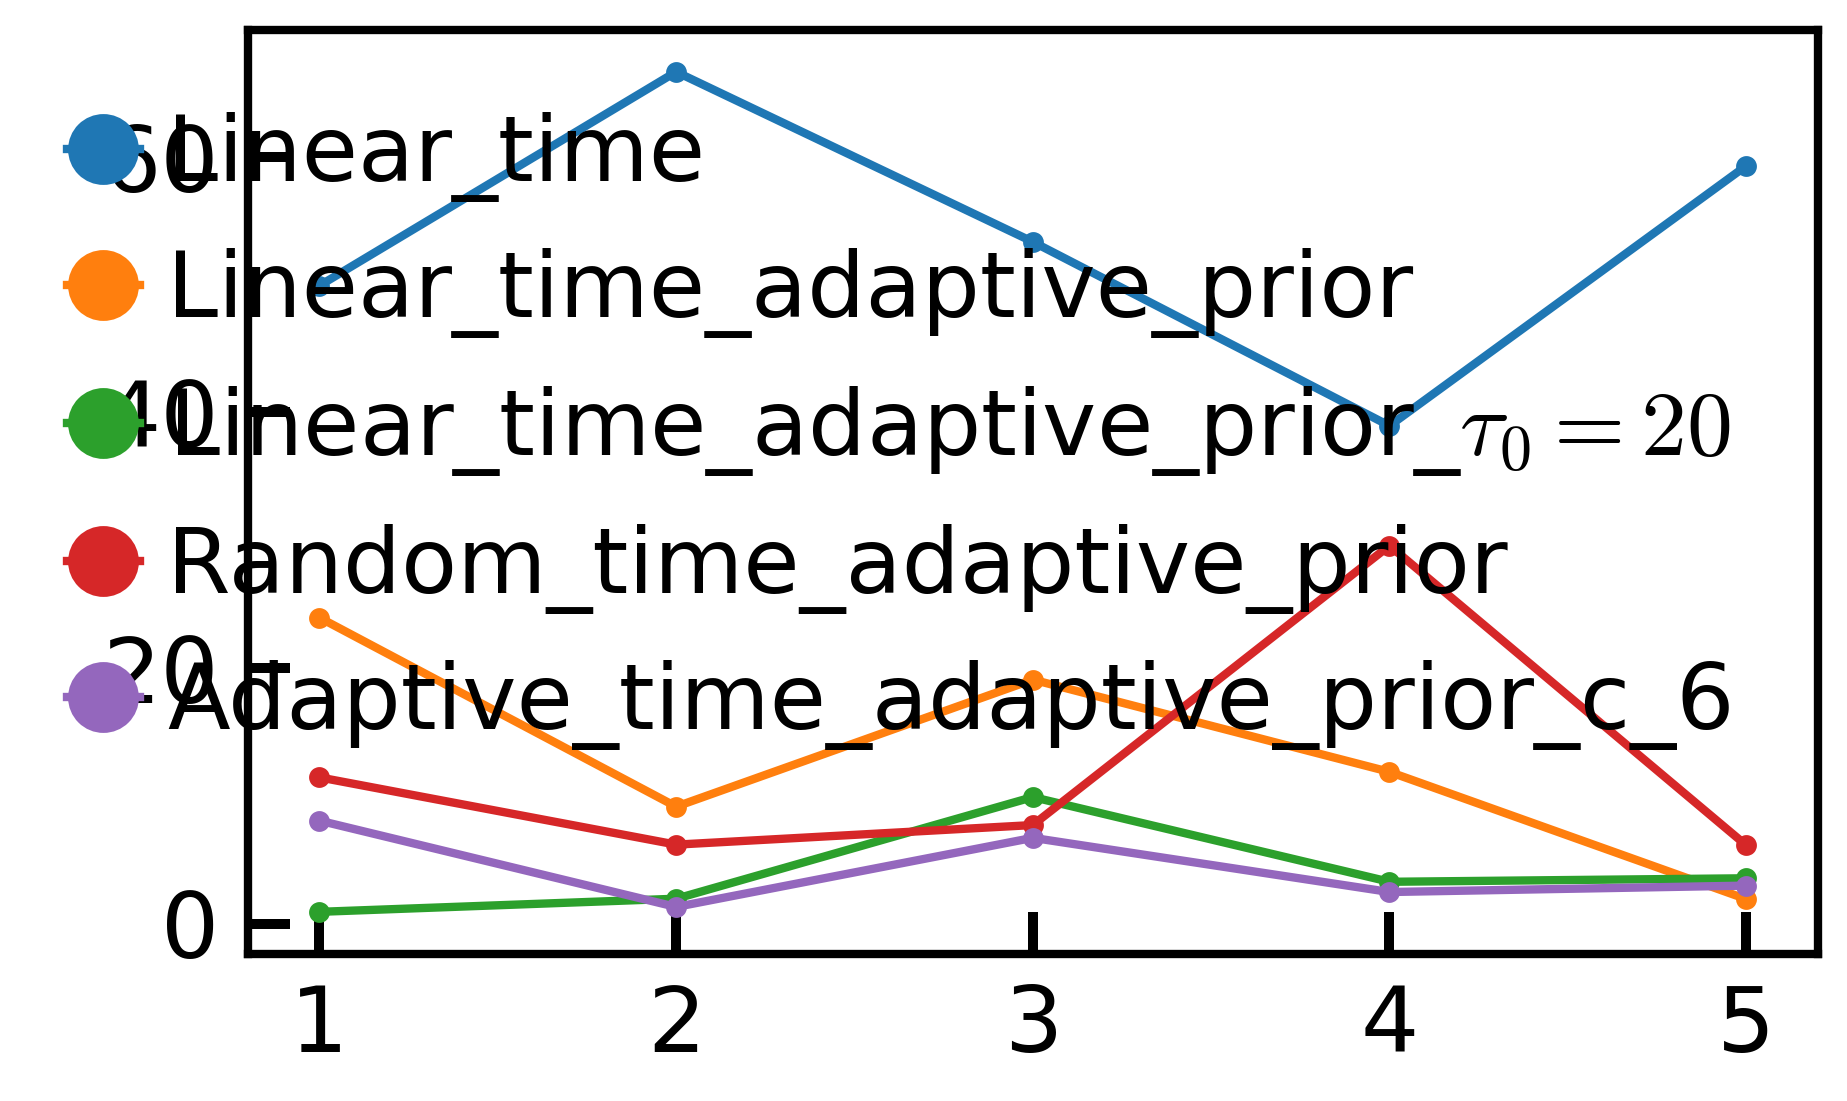

In [49]:
for m in range(5):   
    plt.plot(N_total_shots,  stats_var_r[m,:], label = str(methods[m]))
plt.legend()

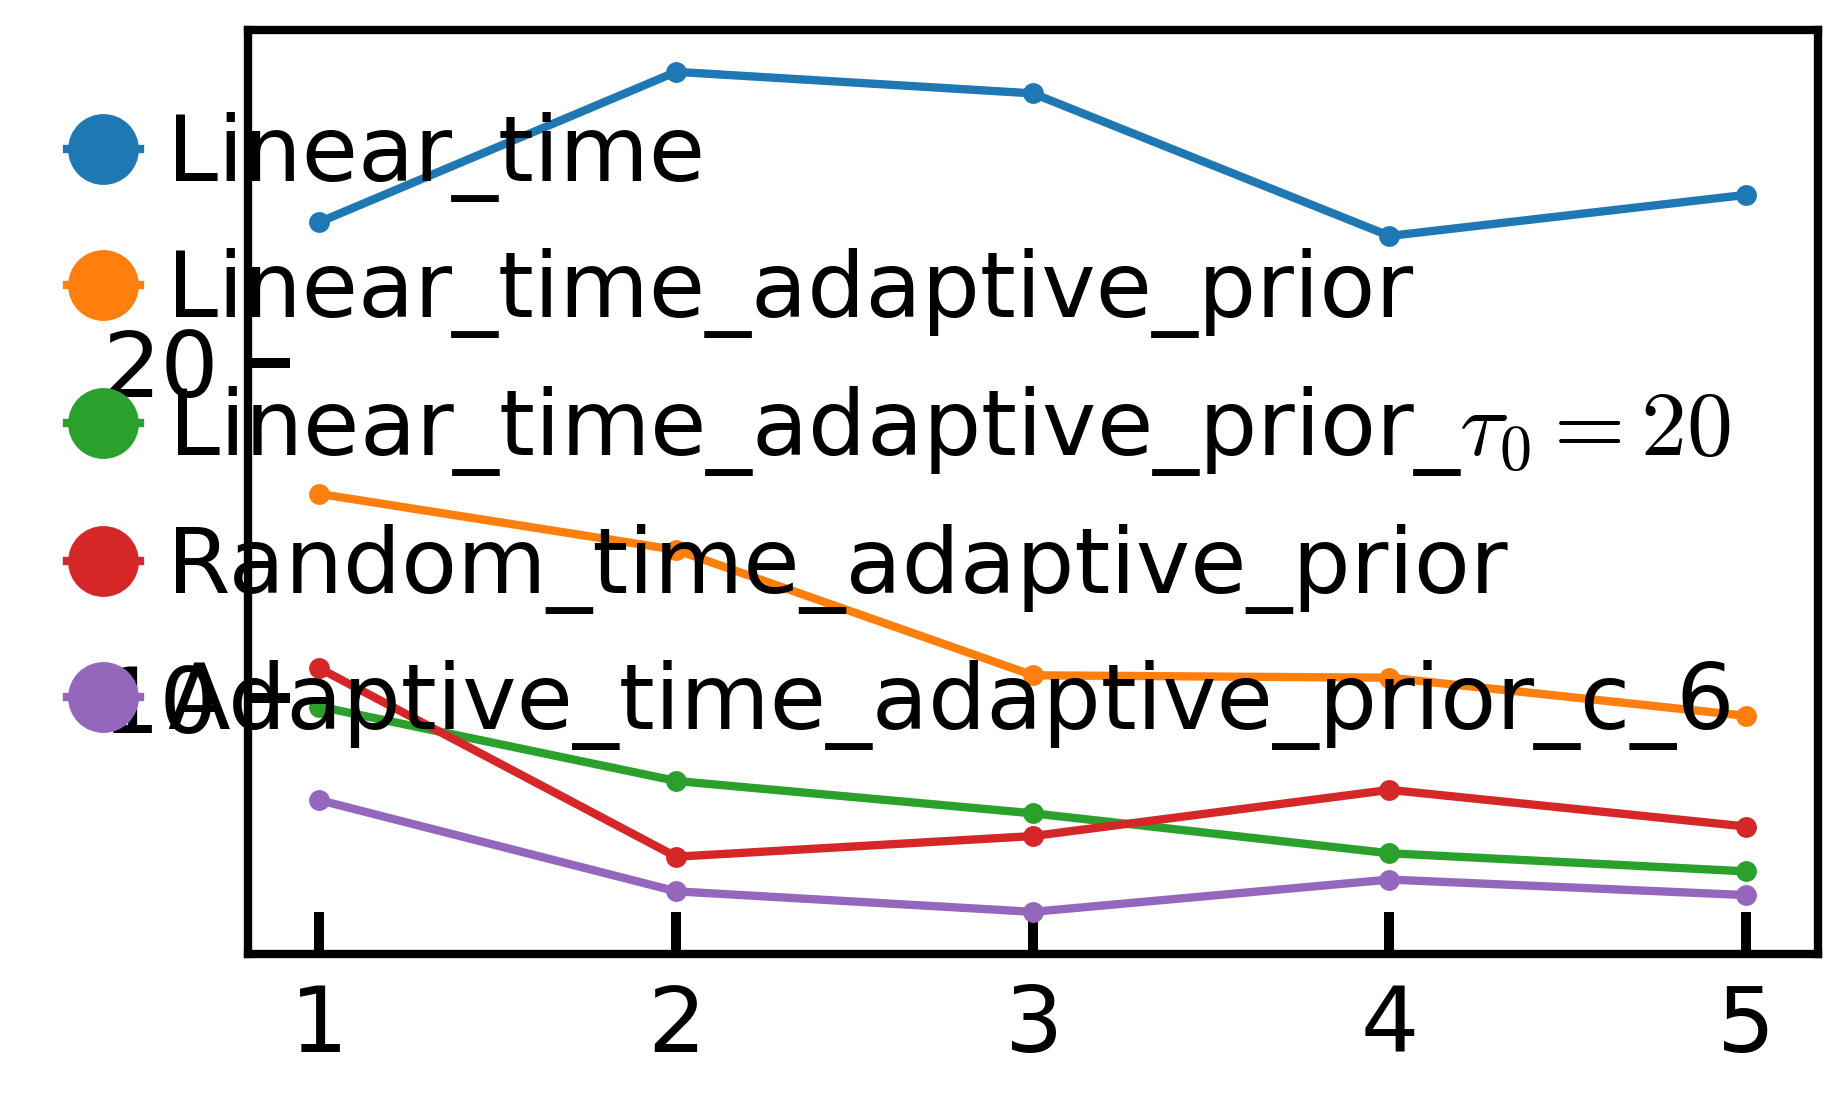

In [50]:
for m in range(5):
    y_std = []

    for k in range(len(N_total_shots)):
        y_std.append(np.mmedian(results_total[k][1][m][:][-1],axis=0))    
    plt.plot(N_total_shots,  y_std, label = str(methods[m]))
plt.legend()